<a href="https://colab.research.google.com/github/jacobadodge/Spring2024_CVENG_8160/blob/main/TRAFFIC_SIGN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# MOUNT DRIVE

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# CHAGNE DIRECTORY

%cd '/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 05 introduction to neural networks'

/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 05 introduction to neural networks


In [3]:
# IMPORT NEEDED MODOULES

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [4]:
# CODE TO USE GPU IF DESIRED (CHANGE RUNTIME TYPE TO GPU)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [23]:
# DATA LOADER

class traffic_sign():
    def __init__(self, root_dir ):

        # initialize dataset variables here
        # self.root = root_dir
        self.root = Path(root_dir)

        self.df = pd.DataFrame(columns = ['image_names','class_label']) # data frame with two columns: image name and class label

        for fldr in self.root.iterdir():
          img_names = []
          if fldr.is_dir():
            img_names = img_names + list(fldr.glob('*.ppm'))
          df_cur = pd.DataFrame(img_names,columns = ['image_names'])
          df_cur['class_label'] = fldr.name
          self.df = pd.concat([self.df, df_cur],axis=0)

        self.df = self.df.sample(frac=1)  # shuffling the data to get all classes
        self.df = self.df.head(1000) # use 500 images

        dummies = pd.get_dummies(data = self.df, columns = ['class_label']) # Each unique value in the 'class_label' column will
        self.df = self.df.merge(dummies, on = 'image_names')                    # be transformed into a new binary column indicating
        self.image_names = list(self.df['image_names'].values)                  # the presence or absence of that value.
        self.class_label = self.df.iloc[:,2:].values.tolist() # 'class_label' is a list of the binary code of the image class
                                                                  # for all rows (:) from columns index 2-end of data frame (2:)


    def __len__(self):
        # returns the length of the dataset
        return len(self.image_names)

    def __getitem__(self, idx):

        # preprocess and transformations
        # indexes the dataset such that dataset[i] can retrieve the ith sample.
        image = self.image_names[idx]

        image_data = io.imread(image)

        label = torch.tensor(self.class_label[idx])

        sample = {'image': image_data, 'label': label}
        scale = Rescale((64,64))
        sample = scale(sample)

        return sample

In [24]:
# INSTANTIATE 'traffic_sign_dataset' FROM 'traffic_sign' CLASS

traffic_sign_dataset = traffic_sign('/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 03 (PyTorch fundamentals and linear regression)')

In [25]:
traffic_sign_dataset.df.head(10)

,image_names,class_label,class_label_00013,class_label_00014,class_label_00029,class_label_00031,class_label_00034,class_label_00040
0,/content/drive/MyDrive/Masters/Semester 1/CVEN...,00031,0,0,0,1,0,0
1,/content/drive/MyDrive/Masters/Semester 1/CVEN...,00013,1,0,0,0,0,0
2,/content/drive/MyDrive/Masters/Semester 1/CVEN...,00029,0,0,1,0,0,0
3,/content/drive/MyDrive/Masters/Semester 1/CVEN...,00031,0,0,0,1,0,0
4,/content/drive/MyDrive/Masters/Semester 1/CVEN...,00040,0,0,0,0,0,1
5,/content/drive/MyDrive/Masters/Semester 1/CVEN...,00031,0,0,0,1,0,0
6,/content/drive/MyDrive/Masters/Semester 1/CVEN...,00040,0,0,0,0,0,1
7,/content/drive/MyDrive/Masters/Semester 1/CVEN...,00014,0,1,0,0,0,0
8,/content/drive/MyDrive/Masters/Semester 1/CVEN...,00013,1,0,0,0,0,0
9,/content/drive/MyDrive/Masters/Semester 1/CVEN...,00031,0,0,0,1,0,0


In [26]:
# CLASS TO RESCALE IMAGES

class Rescale():

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample['image'], sample['label']

        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'label': labels}

In [27]:
for i, sample in enumerate(traffic_sign_dataset):
  print(i, sample['image'].shape, sample['label'])
  if i == 10:
    break

0 (64, 64, 3) tensor([0, 0, 0, 1, 0, 0])
1 (64, 64, 3) tensor([1, 0, 0, 0, 0, 0])
2 (64, 64, 3) tensor([0, 0, 1, 0, 0, 0])
3 (64, 64, 3) tensor([0, 0, 0, 1, 0, 0])
4 (64, 64, 3) tensor([0, 0, 0, 0, 0, 1])
5 (64, 64, 3) tensor([0, 0, 0, 1, 0, 0])
6 (64, 64, 3) tensor([0, 0, 0, 0, 0, 1])
7 (64, 64, 3) tensor([0, 1, 0, 0, 0, 0])
8 (64, 64, 3) tensor([1, 0, 0, 0, 0, 0])
9 (64, 64, 3) tensor([0, 0, 0, 1, 0, 0])
10 (64, 64, 3) tensor([0, 1, 0, 0, 0, 0])


In [28]:
# CLASS TO TRANSFORM IMAGE DATA TO TENSOR

class ToTensor():
    def __call__(self, sample):
        input, output = sample['image'], sample['label']

        return {'image': torch.tensor(np.array(input),dtype=torch.float32).reshape(16,-1),
                'label': torch.tensor(output,dtype=torch.float32).reshape(16,-1)}

In [29]:
# CREATE THE MODEL (NEURAL NETWORK)

model = nn.Sequential(
        nn.Linear(12288, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 6),  # 7 output classes
        nn.Softmax()  # compute softmax, activation function, probability of being in each class
        )
model.to(device)

Sequential(
  (0): Linear(in_features=12288, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=6, bias=True)
  (7): Softmax(dim=None)
)

In [30]:
# DEFINE THE BATCH SIZE AND CREATE THE DATA LOADER

bs = 16
dataloader = DataLoader(traffic_sign_dataset, batch_size=bs, shuffle=True, num_workers=12,drop_last=True)


In [31]:
# ts = ToTensor()
# for i, sample in enumerate(dataloader):
#   # print (sample['image'].size())
#   sample = ts(sample)
#   print (sample['image'].size(), sample['label'].size())
#   if i == 2:
#     break

In [32]:
# DEFINE THE CRITERION (LOSS) AND OPTIMIZER

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
# TRIAN THE MODEL
accuracyLst = []
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
ts = ToTensor()
n_epochs = 10
for it in tqdm(range(n_epochs)):
  # zero the parameter gradients
  for i_batch, sample_batched in enumerate(dataloader):
    optimizer.zero_grad()
    sample_batched = ts(sample_batched)
    outputs = model(sample_batched['image'].to(device))
    loss = criterion(outputs, sample_batched['label'].to(device))
    losses.append(loss.item())

    accuracy = np.argmax(outputs.detach()) == np.argmax(sample_batched['label'].detach())
    if accuracy == True:
      accuracyLst.append(1)
    else:
      accuracyLst.append(0)

    loss.backward()
    optimizer.step()
  mean_loss.append(np.mean(losses))
  print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}')


 10%|█         | 1/10 [00:11<01:46, 11.79s/it]

Epoch 1/10, Training Loss: 1.6393


 20%|██        | 2/10 [00:18<01:09,  8.75s/it]

Epoch 2/10, Training Loss: 1.6197


 30%|███       | 3/10 [00:23<00:50,  7.26s/it]

Epoch 3/10, Training Loss: 1.5445


 40%|████      | 4/10 [00:30<00:42,  7.10s/it]

Epoch 4/10, Training Loss: 1.4953


 50%|█████     | 5/10 [00:36<00:32,  6.47s/it]

Epoch 5/10, Training Loss: 1.4663


 60%|██████    | 6/10 [00:42<00:25,  6.48s/it]

Epoch 6/10, Training Loss: 1.4492


 70%|███████   | 7/10 [00:48<00:18,  6.17s/it]

Epoch 7/10, Training Loss: 1.4321


 80%|████████  | 8/10 [00:54<00:12,  6.34s/it]

Epoch 8/10, Training Loss: 1.4318


 90%|█████████ | 9/10 [01:00<00:06,  6.14s/it]

Epoch 9/10, Training Loss: 1.4313


100%|██████████| 10/10 [01:07<00:00,  6.70s/it]

Epoch 10/10, Training Loss: 1.4223


In [34]:
print('The accuracy of the model is', np.mean(accuracyLst) * 100, '%')

The accuracy of the model is 31.290322580645164 %


In [35]:
# LIST TO TRACK ALL LOSSES

totMeanLoss = []

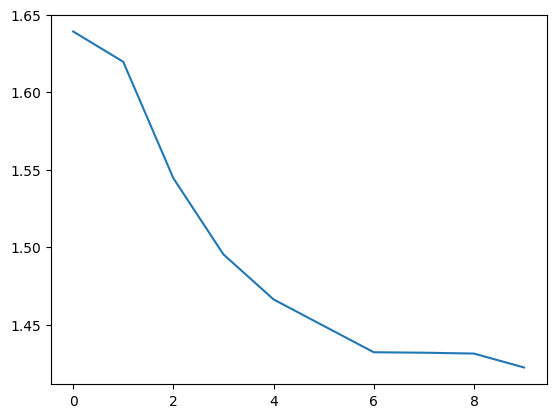

In [36]:
# APPEND ALL LOSSES TO 'totMeanLoss' AND PLOT MOST RECENT TRAINING LOSSS

for item in mean_loss:
  totMeanLoss.append(item)
plt.plot(mean_loss)

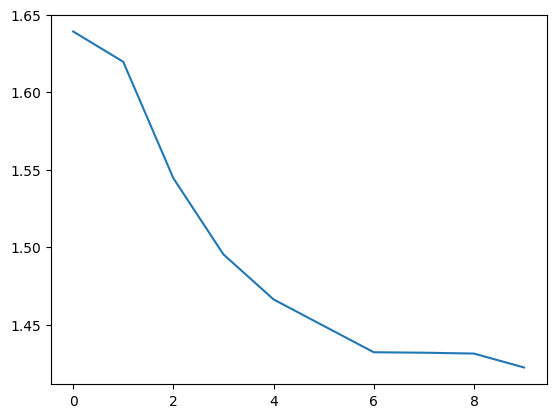

In [37]:
# PLOT ALL LOSSES

plt.plot(totMeanLoss)

In [38]:
# SAVE THE MODEL (TO YOUR CURRENT DIRECTORY)

torch.save(model.state_dict(), 'traffic_model_2.pt')

In [39]:
## load saved model
model_arch = nn.Sequential(
        nn.Linear(12288, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 6)
        )
model_arch.load_state_dict(torch.load('traffic_model_2.pt'))
model_arch.eval()

Sequential(
  (0): Linear(in_features=12288, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=6, bias=True)
)